## 1. Import Libraries

In [25]:
# !pip install pillow tensorflow keras matplotlib numpy split-folders
import zipfile
import os
import shutil
from PIL import Image
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
import splitfolders

## 2. Extract the zip & Combine both folders

In [26]:
with zipfile.ZipFile('/content/archive.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/raw_data')

In [27]:
combined_data_path = '/content/Combined_Sea_Animals'
os.makedirs(combined_data_path, exist_ok=True)

for folder in ['Sea_animals_Data', 'Sea_animals_Data_2']:
    current_path = os.path.join('/content/raw_data', folder)
    for category in os.listdir(current_path):
        category_path = os.path.join(current_path, category)
        save_path = os.path.join(combined_data_path, category)
        os.makedirs(save_path, exist_ok=True)

        for file in os.listdir(category_path):
            src = os.path.join(category_path, file)
            dst = os.path.join(save_path, file)
            shutil.copy2(src, dst)

## 3. Preprocess and crop images

In [28]:
def process_and_crop_images(input_folder, output_folder, target_size=(224, 224)):
    for category in os.listdir(input_folder):
        category_path = os.path.join(input_folder, category)
        save_path = os.path.join(output_folder, category)
        os.makedirs(save_path, exist_ok=True)

        for filename in os.listdir(category_path):
            if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
                try:
                    img_path = os.path.join(category_path, filename)
                    img = Image.open(img_path).convert('RGB')
                    w, h = img.size
                    min_dim = min(w, h)
                    img = img.crop(((w - min_dim) // 2, (h - min_dim) // 2,
                                    (w + min_dim) // 2, (h + min_dim) // 2))
                    img = img.resize(target_size)
                    img.save(os.path.join(save_path, filename))
                except Exception as e:
                    print(f"Error processing {img_path}: {e}")

processed_data_path = '/content/Processed_Sea_Animals'
process_and_crop_images(combined_data_path, processed_data_path)

## 4. Split into train/val/test

In [29]:
splitfolders.ratio(processed_data_path, output="/content/Final_Sea_Animal_Data", seed=42, ratio=(.8, .1, .1))
train_dir = '/content/Final_Sea_Animal_Data/train'
val_dir = '/content/Final_Sea_Animal_Data/val'
test_dir = '/content/Final_Sea_Animal_Data/test'

Copying files: 8480 files [00:01, 5925.55 files/s]


## 5. Create data generators

In [30]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)
val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir, target_size=(224, 224), batch_size=32, class_mode='categorical')

val_generator = val_test_datagen.flow_from_directory(
    val_dir, target_size=(224, 224), batch_size=32, class_mode='categorical')

test_generator = val_test_datagen.flow_from_directory(
    test_dir, target_size=(224, 224), batch_size=32, class_mode='categorical', shuffle=False)

Found 6780 images belonging to 9 classes.
Found 844 images belonging to 9 classes.
Found 856 images belonging to 9 classes.


## 6. Define CNN model

In [31]:
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False

model = tf.keras.models.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(9, activation='softmax')  # 9 sea animal classes
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,423,113 (9.24 MB)

 Trainable params: 165,129 (645.04 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

## 7. Train model

In [32]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint("best_sea_animal_model.h5", save_best_only=True),
    tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
]

history = model.fit(train_generator, epochs=20, validation_data=val_generator, callbacks=callbacks)

Epoch 1/20
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step - accuracy: 0.6670 - loss: 1.0517

212/212 ━━━━━━━━━━━━━━━━━━━━ 96s 413ms/step - accuracy: 0.6674 - loss: 1.0502 - val_accuracy: 0.8519 - val_loss: 0.4460
Epoch 2/20
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step - accuracy: 0.8508 - loss: 0.4705

212/212 ━━━━━━━━━━━━━━━━━━━━ 79s 374ms/step - accuracy: 0.8508 - loss: 0.4705 - val_accuracy: 0.8685 - val_loss: 0.4136
Epoch 3/20
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step - accuracy: 0.8724 - loss: 0.3972

212/212 ━━━━━━━━━━━━━━━━━━━━ 81s 384ms/step - accuracy: 0.8724 - loss: 0.3973 - val_accuracy: 0.8673 - val_loss: 0.4086
Epoch 4/20
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step - accuracy: 0.8807 - loss: 0.3772

212/212 ━━━━━━━━━━━━━━━━━━━━ 80s 380ms/step - accuracy: 0.8807 - loss: 0.3772 - val_accuracy: 0.8827 - val_loss: 0.3700
Epoch 5/20
212/212 ━━━━━━━━━━━━━━━━━━━━ 80s 379ms/step - accuracy: 0.8867 - loss: 0.3440 - val_accuracy: 0.8756 - val_loss: 0.3933
Epoch 6/20
212/212 ━━━━━━━━━━━━━━━━━━━━ 79s 371ms/step - accuracy: 0.9054 - loss: 0.2970 - val_accuracy: 0.8803 - val_loss: 0.4021
Epoch 7/20
212/212 ━━━━━━━━━━━━━━━━━━━━ 80s 377ms/step - accuracy: 0.8969 - loss: 0.2978 - val_accuracy: 0.8803 - val_loss: 0.4024
Epoch 8/20
212/212 ━━━━━━━━━━━━━━━━━━━━ 80s 377ms/step - accuracy: 0.8999 - loss: 0.2927 - val_accuracy: 0.8768 - val_loss: 0.3950
Epoch 9/20
212/212 ━━━━━━━━━━━━━━━━━━━━ 79s 372ms/step - accuracy: 0.9121 - loss: 0.2588 - val_accuracy: 0.8768 - val_loss: 0.3788


## 8. Evaluate model

In [36]:
loss, accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.8901 - loss: 0.3357
Test Accuracy: 89.14%


## 9. Plot performance

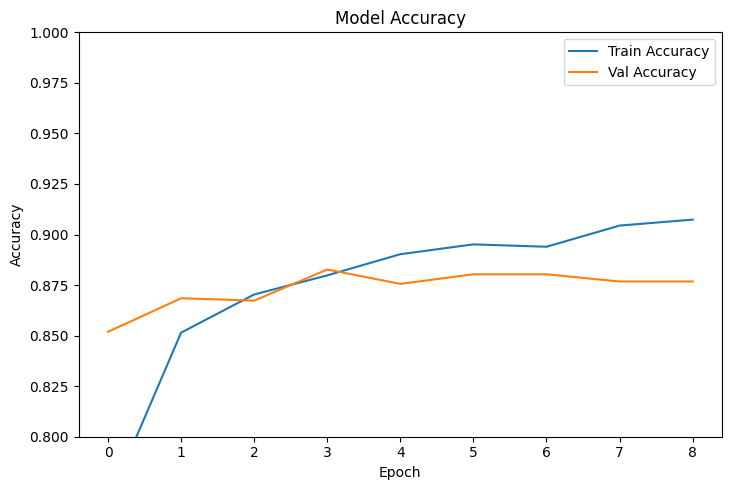

In [38]:
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(0.80, 1.0)
plt.legend()

plt.tight_layout()
plt.show()


## 10. Classify local image

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


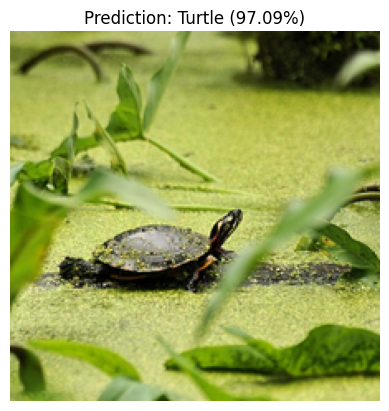

In [47]:
def classify_local_image(image_path):
    try:
        img = Image.open(image_path).convert('RGB')
        w, h = img.size
        min_dim = min(w, h)
        img = img.crop(((w - min_dim) // 2, (h - min_dim) // 2,
                        (w + min_dim) // 2, (h + min_dim) // 2))
        img = img.resize((224, 224))
        img_array = np.expand_dims(np.array(img) / 255.0, axis=0)

        prediction = model.predict(img_array)[0]
        class_index = np.argmax(prediction)
        confidence = np.max(prediction)
        label = list(train_generator.class_indices.keys())[class_index]

        plt.imshow(img)
        plt.axis('off')
        plt.title(f'Prediction: {label} ({confidence*100:.2f}%)')
        plt.show()

    except Exception as e:
        print(f"Error: {e}")

# Example usage (replace with your actual image path)
classify_local_image('/content/Combined_Sea_Animals/Turtle/156c564ede532770.jpg')